# Texas Hold’em Analysis
### Fall 2024 Data Science Project
### Nolan Brennan
## Contributions:
This was a solo project, all portions of the project were created by Nolan Brennan.

## Background information:
Texas Hold’em is the most common variant of poker. The game is played by each player being dealt a 2-card hand. The goal is for each player to create the best 5-card hand out of their 2 cards and 5 shared community cards. Cards are dealt sequentially, with each player first being dealt their hand, followed by 3 community cards (called the flop), then a 4th community card (called the turn), and finally the last community card (called the river). Between each step, all remaining players in the round bet. All players still in the round after betting on the river then reveal their hand to determine the winner (called the showdown). A player can either raise – which means to add more money, call – which means to put in equal money as the previous raise, check – which means to call given no previous raises, or fold – which means to not call and forfeit the round.

## Introduction:
This project will be analyzing a database of 10,000 hands of No-Limit Texas Hold’em poker conducted in a research study. This analysis will attempt to investigate several observed gameplay patterns, attempting to note features of an optimal playstyle. In the data exploration phase of this project, in addition to an observation on finishing stack amounts (the amount of money at the end of the hand), two gameplay features will be investigated. These gameplay features are the proportion of winning compared to table position and which winning hand type wins the most money.  Knowledge of these gameplay concepts will contribute to a winning playstyle, earning a player more money in the long run. Additionally, a machine learning model will be created to determine which hands a player should play vs fold prior to any board information. This concept is called “ranges” in poker, which is a gameplay strategy to only play hands that have a higher than average likelihood of winning before investing in the round.

## Data Curation:
This study observed 5 professional poker players and an AI poker player the researchers developed. The study was conducted over a period of 12 days, with 14 total players swapping in and out. The game was 6-player No-Limit Texas Hold’em, with blinds set at 50/100 points. Individual player points were reset after every round, meaning there was no continuity between hands. This database was selected as it is the largest publicly accessible No-Limit Texas Hold’em database easily findable on the internet. Hand information is given in a standardized format seen below. This format lacks several important observations required for this analysis, though these observations can be extrapolated based on what is given (Ex. Winning player based on which player is remaining).

## Citations:
Brown, Noam, and Tuomas Sandholm. “Superhuman AI for Multiplayer Poker.” Science, vol. 365, no. 6456, 11 July 2019, pp. 885–890, https://doi.org/10.1126/science.aay2400.

uoftcprg. “Phh-Dataset/Data/Pluribus at Main · Uoftcprg/Phh-Dataset.” GitHub, 2024, github.com/uoftcprg/phh-dataset/tree/main/data/pluribus. Accessed 3 Dec. 2024.



## Exploratory data analysis:
See graphs in .ipynb file.



## Primary Analysis:
A Random Forest Model was used to predict whether a player should play or not play a hand prior to any information being given. This is a classification problem, meaning that the model should either give a 0 or 1 to not play or play respectively. Random Forest was selected as it allows for the data to be trained and tested amongst the whole dataset, which despite being 10,000 hands, is still size constrained due to the total number of possible hands. Random forest is also a classification model, intended for similar problems.

## Results of Primary Analysis:
This model is able to predict not-playing hands with a high F1 score. However, the model is not able to predict playing hands very accurately, with only a 0.45 F1 score. This model may be improved upon with a larger dataset, as not playing hands are overrepresented in the dataset.

## Insights and Conclusions:
This project successfully informs an uninformed and informed audience, primarily providing insights into three specific gameplay features. These gameplay features are table position’s correlation to winning, winning hand type expected value, and hand ranges. These gameplay features contribute to a winning strategy in poker and are implemented in high-level gameplay. For novice/uninformed players the table position graph demonstrates how position two (the big blind) and position six (the button) win the most hands. This comes down to two innate facts of the game, those being that the big blind is the last person to bet during the first round and the button is the last to bet in all other rounds. Since a significant portion of hands make it past the first round, the position two player is able to raise and get all other players to fold. In all other rounds, this dominant position becomes the button. This game dynamic would be insightful to a new player, though even to a more experienced player, the fact that the big blind wins most games would also be insightful. This is because most gameplay attention is given to the button position, with the big blind position being overlooked. Additionally, winning hand type expected value was the most significant finding, presenting information that is not discussed even amongst professional players. Ignoring the outlier of royal flushes, full houses were shown to earn the most money on average. This suggests that players can raise the most for full houses, adding to a competitive strategy for an informed and uninformed player. Finally, the hand range model enabled the prediction of which initial hands to play and which to not play. This model can be used by any level of informed audience to increase the likelihood of playing a winning hand.


Data exported to phh_data_extracted.csv
Descriptive Statistics for Finishing Stacks:
The ending stacks are normally distributed
median   10000.0
count    60000.000000
mean     10000.000000
std        904.739525
min          0.000000
25%       9950.000000
50%      10000.000000
75%      10000.000000
max      30200.000000
Name: finishing_stacks, dtype: float64


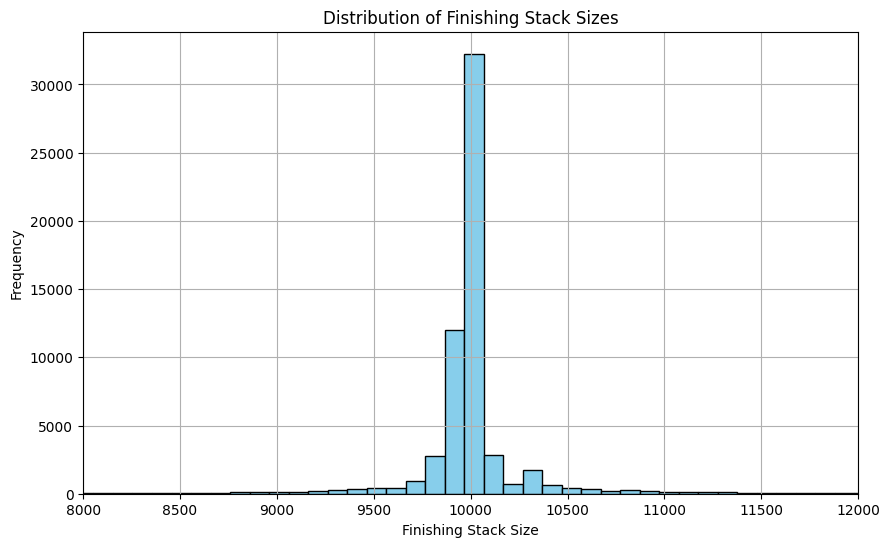

Chi-Square Test Results:
Chi-Square Statistic: 1472.8808000000001
P-value: 0.0
There is a statistically significant relationship between player position and winning.


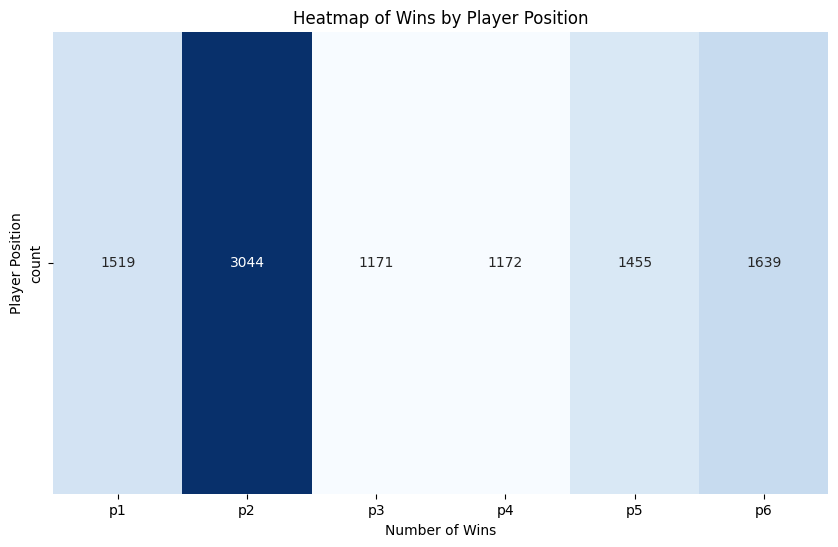

ANOVA Test Results:
F-statistic: 201.9161, p-value: 0.0000
There is a statistically significant difference in average winnings among different winning hand types.


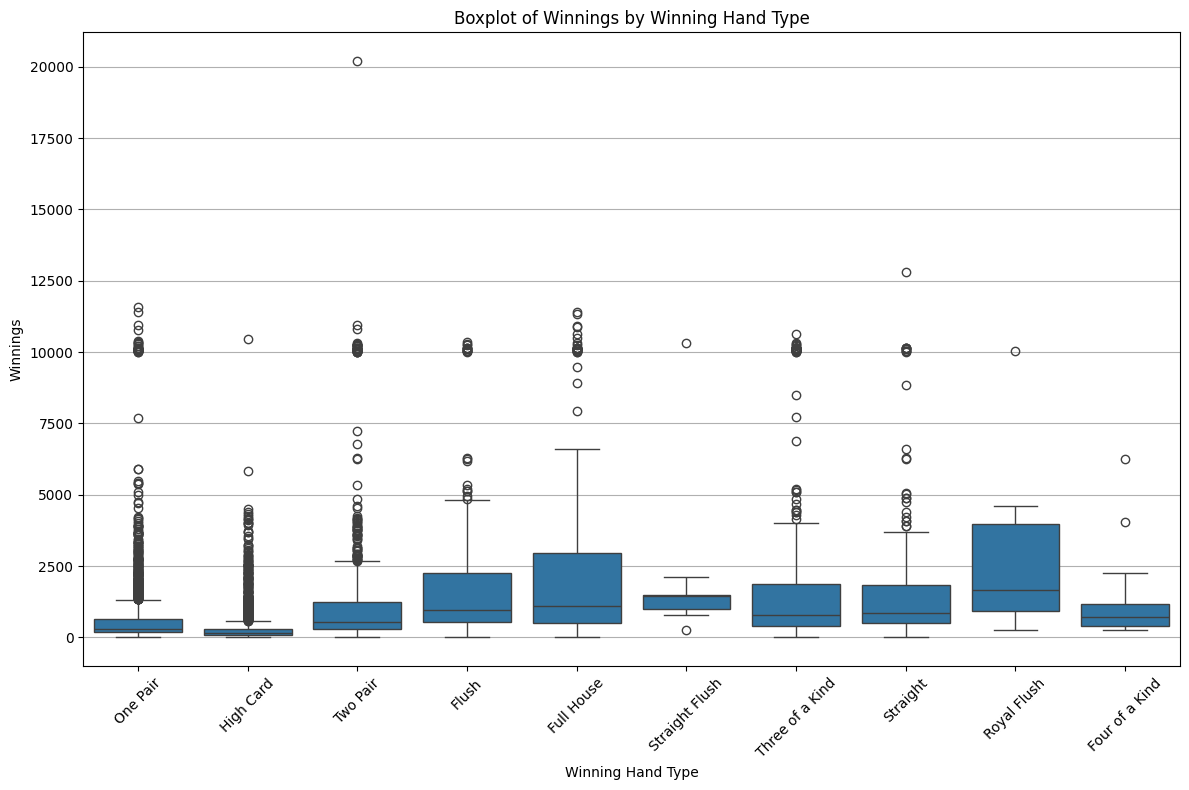

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      9984
           1       0.50      0.42      0.45      2016

    accuracy                           0.83     12000
   macro avg       0.69      0.67      0.68     12000
weighted avg       0.82      0.83      0.82     12000



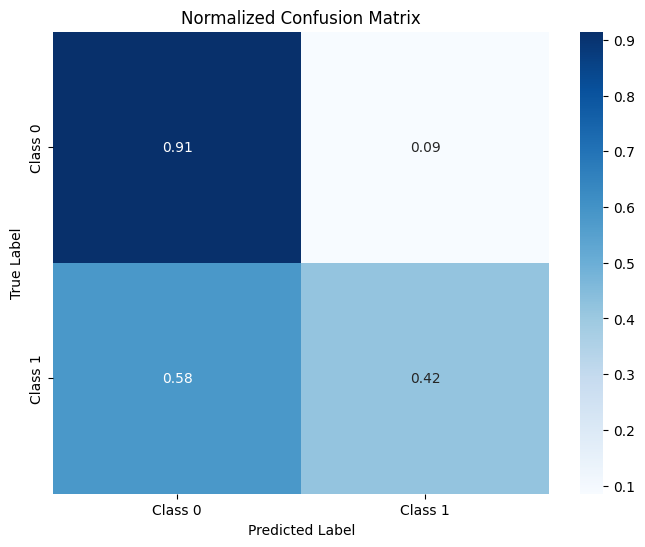

In [ ]:
import os
import re
import pandas as pd
from git import Repo
import shutil
from collections import Counter
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Function to delete directory if it exists
def delete_existing_directory(dir_path):
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)

# Function to convert string lists to actual lists of floats
def convert_to_float_list(string_list):
    return list(map(float, string_list.split(',')))

# Function to find the winner of the hand based on finishing stacks
def find_winner(players, finishing_stacks):
    max_stack = max(finishing_stacks)
    winner_index = finishing_stacks.index(max_stack)
    winner_name = players[winner_index]
    winner_player_number = f"p{winner_index + 1}"
    return winner_player_number, winner_name, winner_index

# Function to extract player hands from the actions
def extract_player_hands(actions):
    player_hands = []
    for action in actions:
        match = re.search(r'p\d+ (\w{2}\w{2})', action)
        if match:
            player_hands.append(match.group(1))
    return player_hands

# Function to extract community cards from actions
def extract_community_cards(actions):
    community_cards = []
    for action in actions:
        match = re.search(r'd db (\w{2,})', action)
        if match:
            community_cards.append(match.group(1))
    return ''.join(community_cards)

# Function to evaluate the poker hand
def evaluate_poker_hand(winner_hand, community_cards):
    combined_hand = winner_hand + community_cards
    def card_rank(card):
        rank_dict = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'T': 10,
                      'J': 11, 'Q': 12, 'K': 13, 'A': 14}
        return rank_dict[card[0]]

    ranks = sorted([card_rank(card) for card in [combined_hand[i:i+2] for i in range(0, len(combined_hand), 2)]], reverse=True)
    suits = [combined_hand[i+1] for i in range(0, len(combined_hand), 2)]
    suit_counts = Counter(suits)
    flush = any(count >= 5 for count in suit_counts.values())
    rank_counts = Counter(ranks)
    distinct_ranks = sorted(set(ranks), reverse=True)

    straight = False
    for i in range(len(distinct_ranks) - 4):
        if distinct_ranks[i] - distinct_ranks[i + 4] == 4:
            straight = True
            break

    if flush and straight and 14 in ranks and 13 in ranks:
        return "Royal Flush"
    if flush and straight:
        return "Straight Flush"
    if 4 in rank_counts.values():
        return "Four of a Kind"
    if 3 in rank_counts.values() and 2 in rank_counts.values():
        return "Full House"
    if flush:
        return "Flush"
    if straight:
        return "Straight"
    if 3 in rank_counts.values():
        return "Three of a Kind"
    if list(rank_counts.values()).count(2) == 2:
        return "Two Pair"
    if 2 in rank_counts.values():
        return "One Pair"
    return "High Card"

# Function to extract variables from the contents of a .phh file
def extract_phh_variables(contents):
    variant = re.search(r"variant = '(.*?)'", contents).group(1)
    ante_trimming_status = re.search(r"ante_trimming_status = (true|false)", contents).group(1) == "true"
    antes = re.search(r"antes = \[(.*?)\]", contents).group(1)
    blinds_or_straddles = re.search(r"blinds_or_straddles = \[(.*?)\]", contents).group(1)
    min_bet = int(re.search(r"min_bet = (\d+)", contents).group(1))
    starting_stacks = re.search(r"starting_stacks = \[(.*?)\]", contents).group(1)
    actions = re.search(r"actions = \[(.*?)\]", contents, re.DOTALL).group(1)
    hand = int(re.search(r"hand = (\d+)", contents).group(1))
    players = re.search(r"players = \[(.*?)\]", contents).group(1)
    finishing_stacks = re.search(r"finishing_stacks = \[(.*?)\]", contents).group(1)

    antes = convert_to_float_list(antes)
    blinds_or_straddles = convert_to_float_list(blinds_or_straddles)
    starting_stacks = convert_to_float_list(starting_stacks)
    finishing_stacks = convert_to_float_list(finishing_stacks)

    players = players.replace("'", "").split(", ")
    actions = actions.replace("'", "").split(", ")

    player_hands = extract_player_hands(actions)
    community_cards = extract_community_cards(actions)

    winner_player_number, winner_player_name, winner_index = find_winner(players, finishing_stacks)
    winner_hand = player_hands[winner_index] if winner_index < len(player_hands) else None

    if winner_index < len(starting_stacks):
        winnings = finishing_stacks[winner_index] - starting_stacks[winner_index]
    else:
        winnings = None

    if winner_hand:
        winning_hand_type = evaluate_poker_hand(winner_hand, community_cards)
    else:
        winning_hand_type = None

    return {
        "variant": variant,
        "ante_trimming_status": ante_trimming_status,
        "antes": antes,
        "blinds_or_straddles": blinds_or_straddles,
        "min_bet": min_bet,
        "starting_stacks": starting_stacks,
        "actions": actions,
        "hand": hand,
        "players": players,
        "finishing_stacks": finishing_stacks,
        "player_hands": player_hands,
        "community_cards": community_cards,
        "winner_player_number": winner_player_number,
        "winner_player_name": winner_player_name,
        "winner_hand": winner_hand,
        "winning_hand_type": winning_hand_type,
        "winnings": winnings
    }

def plot_finishing_stacks_distribution(df):
    finishing_stacks = df['finishing_stacks'].explode().astype(float)
    plt.figure(figsize=(10, 6))
    plt.hist(finishing_stacks, bins=300, color='skyblue', edgecolor='black')
    plt.xlim(8000, 12000)
    plt.title('Distribution of Finishing Stack Sizes')
    plt.xlabel('Finishing Stack Size')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

def print_descriptive_stats(finishing_stacks):
    descriptive_stats = finishing_stacks.describe()
    median_value = finishing_stacks.median()
    print("Descriptive Statistics for Finishing Stacks:")
    print("The ending stacks are normally distributed")
    print(f"median   {median_value}")
    print(descriptive_stats)

def plot_winnings_boxplot(df):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='winning_hand_type', y='winnings', data=df)
    plt.title('Boxplot of Winnings by Winning Hand Type')
    plt.xlabel('Winning Hand Type')
    plt.ylabel('Winnings')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

def perform_anova_test(df):
    # Group winnings by winning hand type
    anova_data = df.groupby('winning_hand_type')['winnings'].apply(list).dropna()  # Group by hand type
    anova_results = stats.f_oneway(*anova_data)  # Perform ANOVA

    print("ANOVA Test Results:")
    print(f"F-statistic: {anova_results.statistic:.4f}, p-value: {anova_results.pvalue:.4f}")

    # Interpretation of the results
    alpha = 0.05
    if anova_results.pvalue < alpha:
        print("There is a statistically significant difference in average winnings among different winning hand types.")
    else:
        print("There is not a statistically significant difference in average winnings among different winning hand types.")

def player_position_vs_winning_heatmap(df):
    # Count wins by player position
    win_counts = df['winner_player_number'].value_counts().sort_index()

    # Perform Chi-Square Test
    total_hands = len(df)
    expected_counts = [total_hands / len(win_counts)] * len(win_counts)  # Expected counts assuming equal wins per position
    observed_counts = win_counts.values  # Observed win counts by player position
    chi2, p = stats.chisquare(f_obs=observed_counts, f_exp=expected_counts)

    # Print Chi-Square test results
    print("Chi-Square Test Results:")
    print(f"Chi-Square Statistic: {chi2}")
    print(f"P-value: {p}")
    if p < 0.05:
        print("There is a statistically significant relationship between player position and winning.")
    else:
        print("There is no statistically significant relationship between player position and winning.")

    # Create a heatmap of win proportions by player position
    plt.figure(figsize=(10, 6))
    sns.heatmap(win_counts.to_frame().T, annot=True, cmap="Blues", cbar=False, fmt="d")
    plt.title('Heatmap of Wins by Player Position')
    plt.ylabel('Player Position')
    plt.xlabel('Number of Wins')
    plt.show()

def extract_features_and_labels(df):
    features = []
    labels = []

    for idx, row in df.iterrows():
        # Get the hands of all players and the winner
        player_hands = row['player_hands']
        winner_player_number = row['winner_player_number']

        for position, hand in enumerate(player_hands, start=1):
            if len(hand) != 4:
                continue
            # Split the hand into individual cards
            card_1, card_2 = hand[:2], hand[2:]

            # Map card ranks to numbers
            rank_mapping = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7,
                            '8': 8, '9': 9, 'T': 10, 'J': 11, 'Q': 12, 'K': 13, 'A': 14}

            card_1_rank = rank_mapping.get(card_1[0], 0)
            card_1_suit = card_1[1]
            card_2_rank = rank_mapping.get(card_2[0], 0)
            card_2_suit = card_2[1]

            # Feature vector for this player's hand
            feature = {
                'card_1_rank': card_1_rank,
                'card_1_suit': card_1_suit,
                'card_2_rank': card_2_rank,
                'card_2_suit': card_2_suit,
                'position': position
            }
            features.append(feature)

            # Check if this player won
            label = 1 if winner_player_number == f'p{position}' else 0
            labels.append(label)

    X = pd.DataFrame(features)

    suit_mapping = {'h': 0, 'd': 1, 'c': 2, 's': 3}
    X['card_1_suit'] = X['card_1_suit'].map(suit_mapping)
    X['card_2_suit'] = X['card_2_suit'].map(suit_mapping)

    y = pd.Series(labels)

    return X, y






# Function to clone the repository, read .phh files, extract data, and export to CSV
def clone_repo_and_export_to_csv(repo_url, clone_dir, extract_folder, output_csv):
    try:
        delete_existing_directory(clone_dir)

        Repo.clone_from(repo_url, clone_dir)

        data_folder = os.path.join(clone_dir, extract_folder)

        data = []

        if os.path.exists(data_folder):
            for root, dirs, files in os.walk(data_folder):
                for file in files:
                    if file.endswith(".phh"):
                        file_path = os.path.join(root, file)
                        with open(file_path, 'r') as f:
                            contents = f.read()
                            extracted_data = extract_phh_variables(contents)
                            extracted_data["file_name"] = file
                            data.append(extracted_data)

            df = pd.DataFrame(data)
            df.to_csv(output_csv, index=False)
            print(f"Data exported to {output_csv}")


            # Descriptive statistics for finishing stacks
            finishing_stacks = df['finishing_stacks'].explode().astype(float)
            print_descriptive_stats(finishing_stacks)

            # Plot distribution of finishing stacks
            plot_finishing_stacks_distribution(df)

            # Player position vs winning heatmap
            player_position_vs_winning_heatmap(df)

            # ANOVA Test Section
            perform_anova_test(df)

            # Plot boxplot for winnings by winning hand type
            plot_winnings_boxplot(df)


            # Extract features and labels
            X, y = extract_features_and_labels(df)

            # Split the data into train and test sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # Initialize the Random Forest model
            model = RandomForestClassifier(n_estimators=100, random_state=42)

            # Train the model
            model.fit(X_train, y_train)

            # Evaluate the model
            y_pred = model.predict(X_test)

            # Output classification report
            print(classification_report(y_test, y_pred))

            # Generate confusion matrix
            cm = confusion_matrix(y_test, y_pred)

            # Normalize the confusion matrix by row
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            # Plot using seaborn for better visualization
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
            plt.title('Normalized Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()


        else:
            print(f"Folder '{extract_folder}' not found in the repository.")

    except Exception as e:
        print(f"Error: {e}")

# GitHub repository URL and local clone directory
repo_url = "https://github.com/uoftcprg/phh-dataset.git"
clone_dir = "./phh-dataset"
extract_folder = "data/pluribus"
output_csv = "phh_data_extracted.csv"

# Clone the repository, extract variables, create a DataFrame, and export to CSV
clone_repo_and_export_to_csv(repo_url, clone_dir, extract_folder, output_csv)
